In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
df = pd.read_csv('crime.csv', encoding='latin-1')
df.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [3]:
df= df.head(10000)
df.shape

(10000, 17)

In [4]:
df = df.drop(columns=['INCIDENT_NUMBER'], axis=1)


# date time 
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE'])
# Extract date features
df['YEAR'] = df['OCCURRED_ON_DATE'].dt.year
df['MONTH'] = df['OCCURRED_ON_DATE'].dt.month
df['DAY'] = df['OCCURRED_ON_DATE'].dt.day
df['HOUR'] = df['OCCURRED_ON_DATE'].dt.hour


# Transform location data into latitude and longitude features
df['LATITUDE'] = df['Location'].str.extract(r'\(([-+]?[0-9]*\.?[0-9]+),\s*([-+]?[0-9]*\.?[0-9]+)\)')[0].astype(float)
df['LONGITUDE'] = df['Location'].str.extract(r'\(([-+]?[0-9]*\.?[0-9]+),\s*([-+]?[0-9]*\.?[0-9]+)\)')[1].astype(float)

df.drop(columns=['Location', 'Lat', 'Long'], axis=1, inplace=True)


# Split the REPORTING_AREA feature into numeric and non-numeric components
df['REPORTING_AREA'] = df['REPORTING_AREA'].str.extract(r'(\d+)')[0].astype(float)
df['REPORTING_AREA_STR'] = df['REPORTING_AREA'].astype(str)
df.drop('REPORTING_AREA', axis=1, inplace=True)


df.drop(columns=['OFFENSE_DESCRIPTION', 'OCCURRED_ON_DATE'], axis=1,inplace=True)

In [5]:
# Define categorical and numerical features
categorical_columns = ['DAY_OF_WEEK', 'DISTRICT', 'UCR_PART', 'STREET', 'REPORTING_AREA_STR','SHOOTING']
onehot_encoder = OneHotEncoder(sparse=False)


In [6]:
# One-hot encoding of Categorical columns
categorical_data = df[categorical_columns]
onehot_encoded_data = onehot_encoder.fit_transform(categorical_data)
print(f"Categorical data : {onehot_encoded_data.shape}")

Categorical data : (10000, 2671)


/Users/rishikeshsolapure/Desktop/Crime-Data-Analysis/cda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
onehot_encoded_data

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(onehot_encoded_data)
print(X_pca)

[[ 3.94514088e-01  9.28417590e-01 -2.53001894e-02 ...  1.47411863e-03
   1.25233250e-03 -3.50618951e-02]
 [ 7.67422269e-01 -5.03460495e-01 -5.33257821e-02 ... -1.40873622e-02
   1.01089276e-02  7.48802257e-03]
 [-5.40406287e-01  9.80776170e-02  7.33832908e-01 ... -1.22839948e-02
   1.27115788e-03  5.22776663e-04]
 ...
 [ 4.50173616e-01  9.81114757e-01 -5.23691111e-02 ...  1.79851539e-04
  -2.86569605e-03  3.58373594e-03]
 [ 3.96569744e-01  8.82356909e-01 -2.77361168e-02 ...  3.19098525e-04
   2.43507286e-03  4.47398899e-03]
 [ 4.40614087e-01  9.02908251e-01 -1.19372852e-02 ... -3.45349164e-04
   7.59612466e-04  1.17169248e-04]]


In [7]:
X_df = pd.DataFrame(onehot_encoded_data)

# Find frequent itemsets
frequent_itemsets = apriori(X_df, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print(rules)

rules_filtered = rules.query("lift > 1.2")
print(rules_filtered)


/Users/rishikeshsolapure/Desktop/Crime-Data-Analysis/cda/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


   antecedents consequents  antecedent support  consequent support  support  \
0          (0)      (2670)              0.1532              0.9977   0.1532   
1       (2670)         (0)              0.9977              0.1532   0.1532   
2          (1)      (2670)              0.1535              0.9977   0.1533   
3       (2670)         (1)              0.9977              0.1535   0.1533   
4          (2)        (22)              0.1338              0.5231   0.0722   
..         ...         ...                 ...                 ...      ...   
71        (12)  (2670, 22)              0.1222              0.5228   0.0672   
72      (2670)    (12, 22)              0.9977              0.0672   0.0672   
73        (22)  (12, 2670)              0.5231              0.1219   0.0672   
74    (22, 15)      (2670)              0.0555              0.9977   0.0555   
75      (2670)    (22, 15)              0.9977              0.0555   0.0555   

    confidence      lift  leverage  conviction  zha

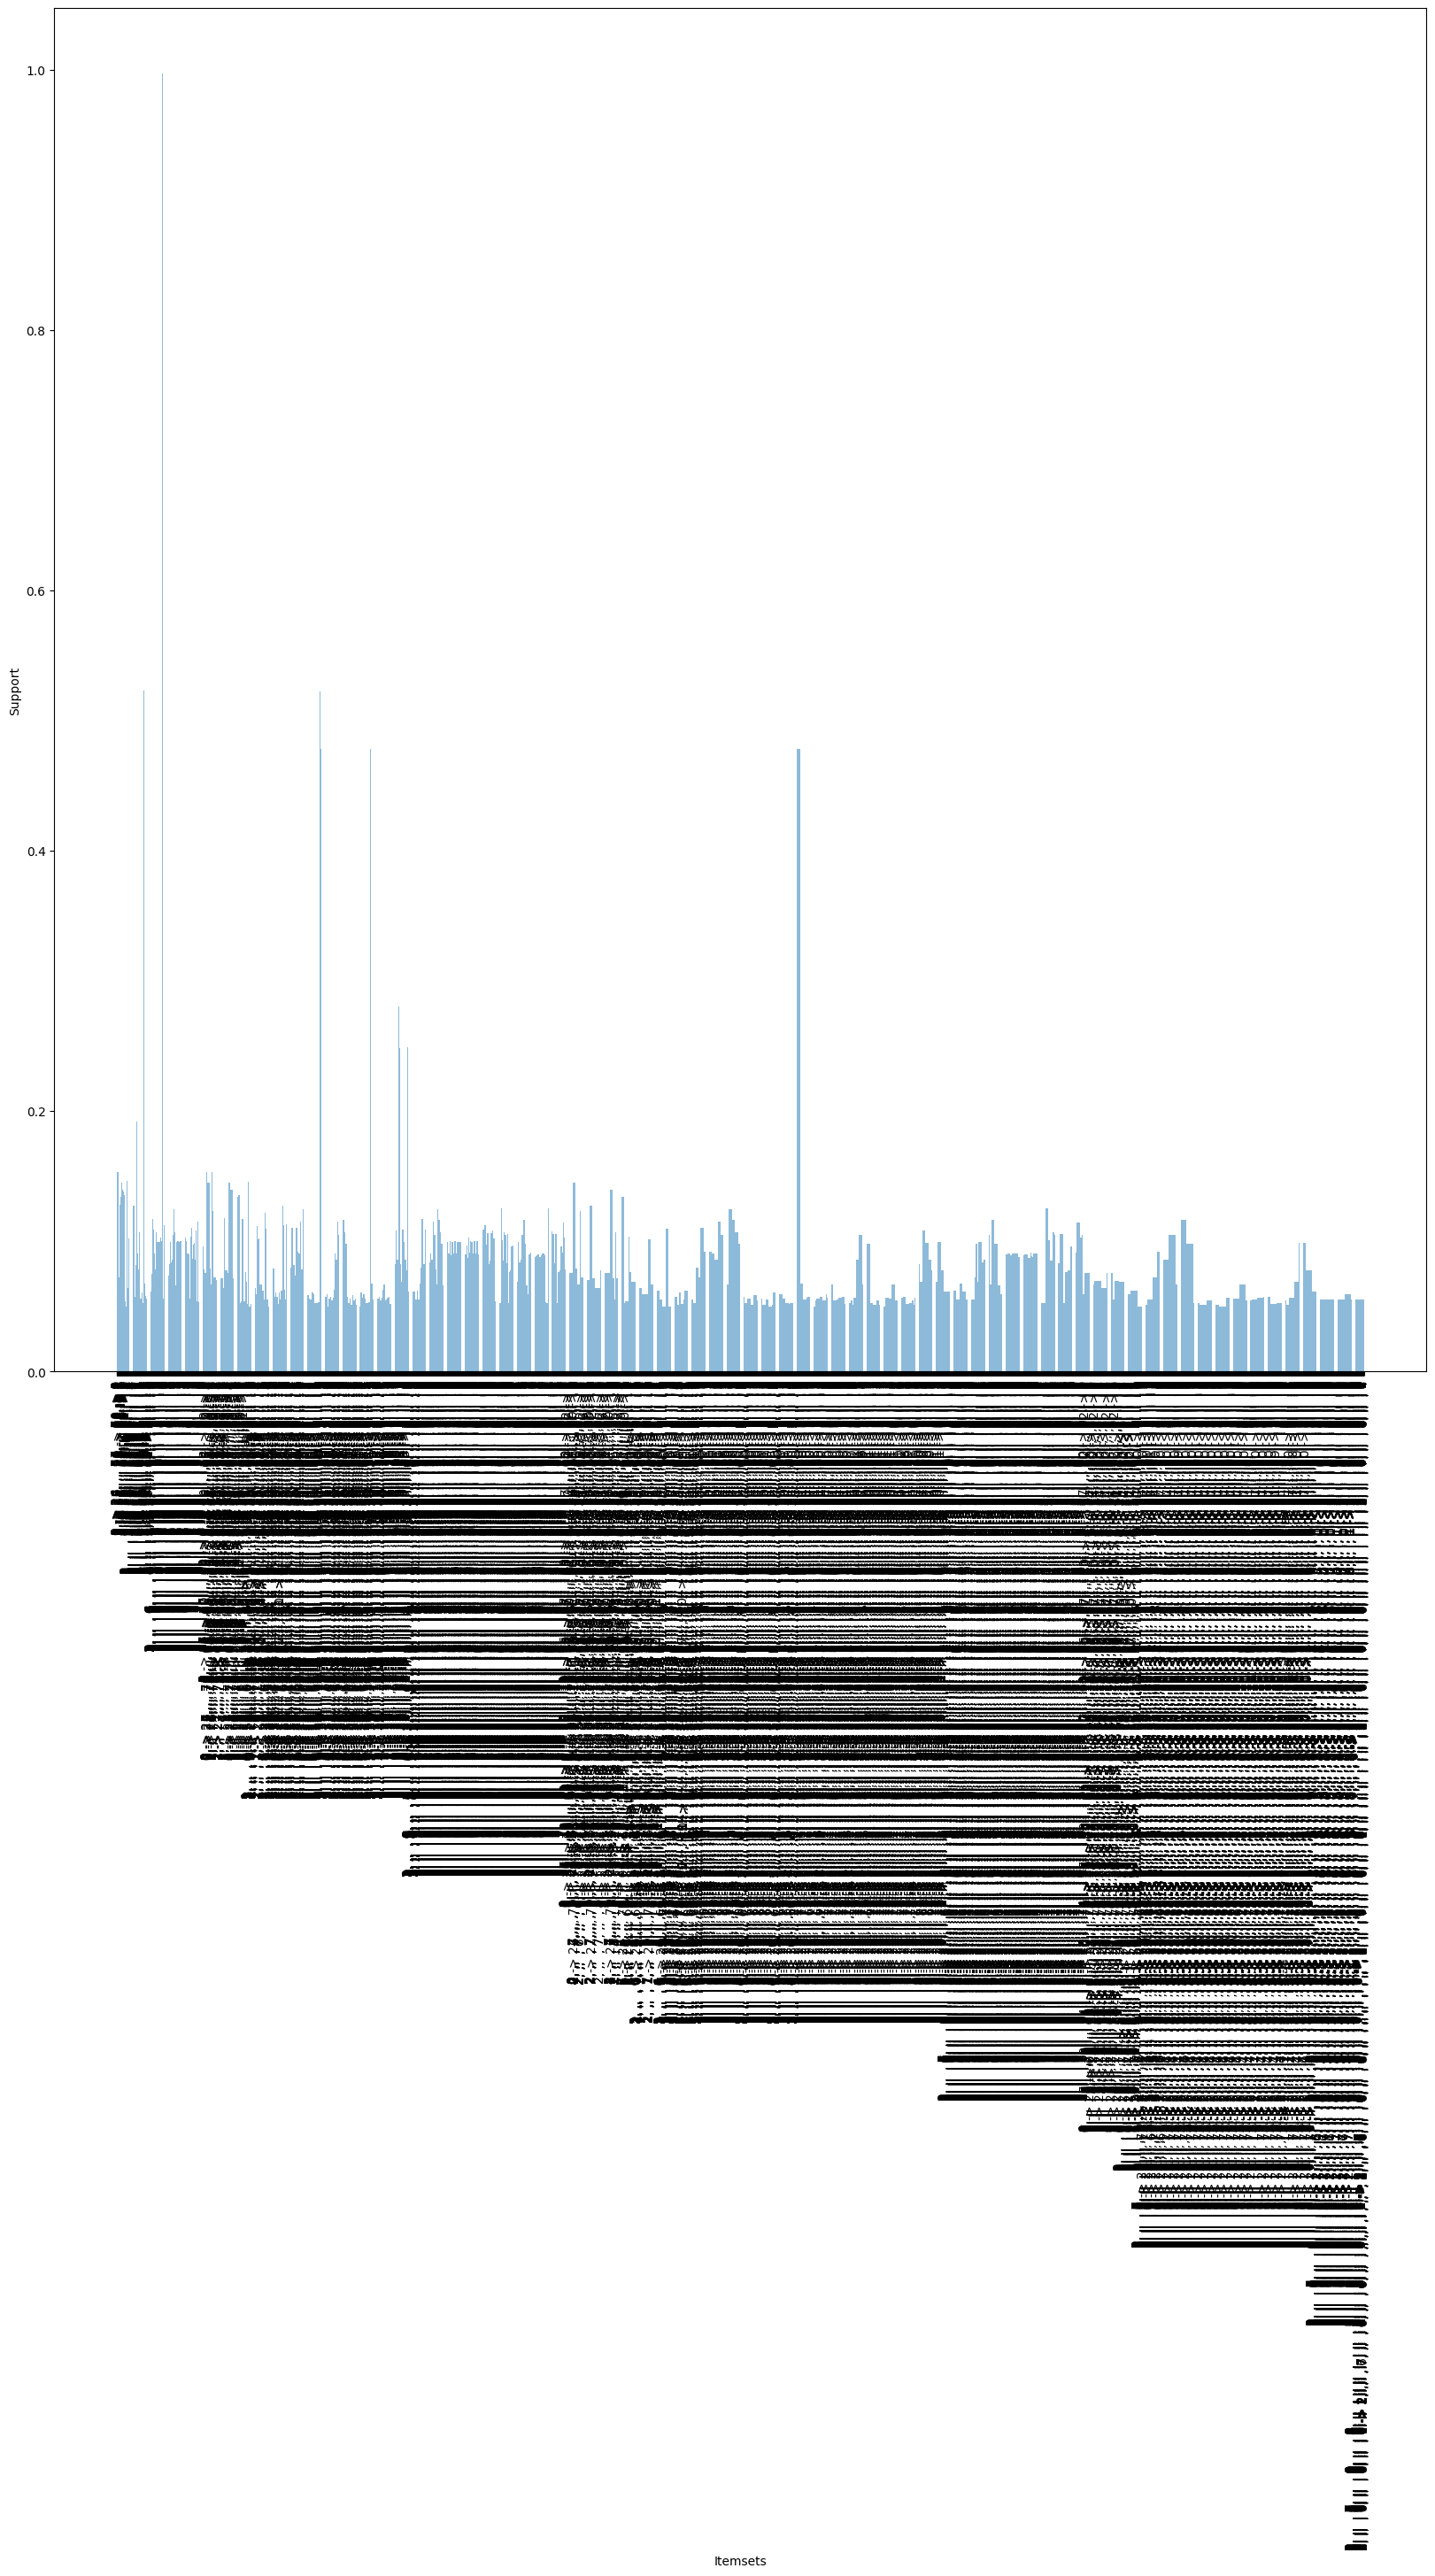

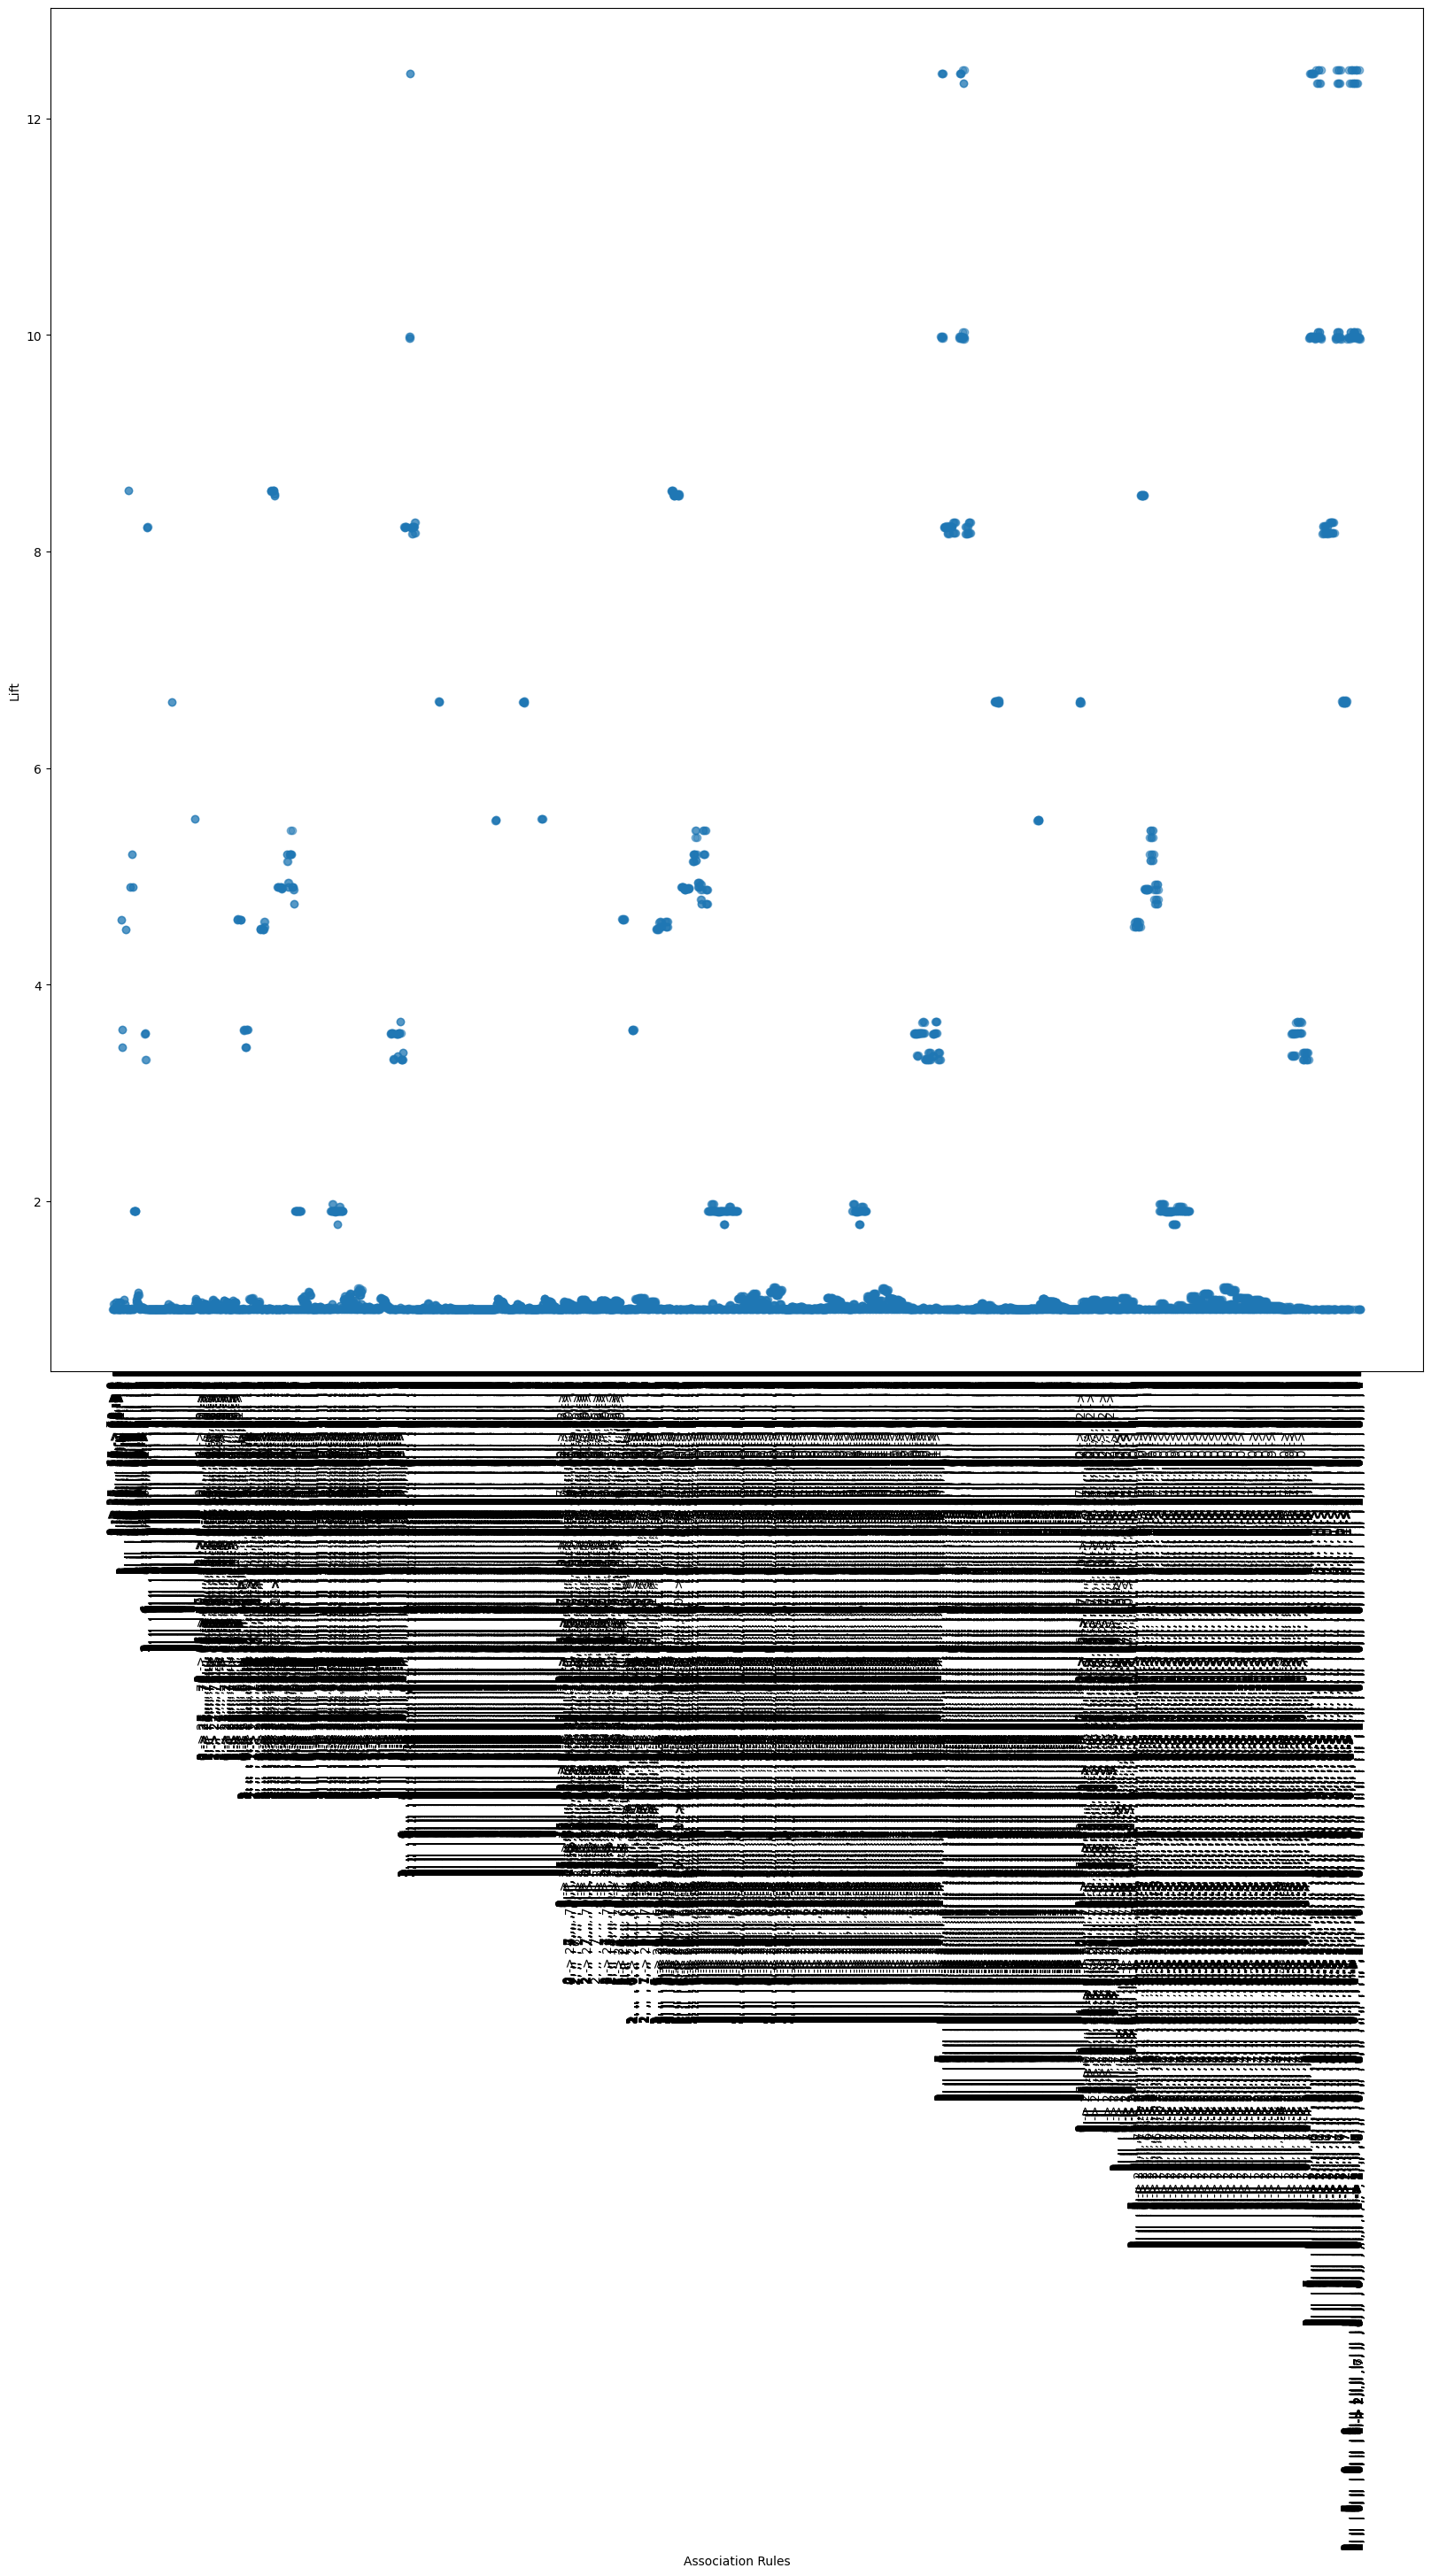

In [ ]:
import matplotlib.pyplot as plt

# Convert antecedents and consequents to strings
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(str(i) for i in x))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(str(i) for i in x))

# Plot frequent itemsets
fig, ax = plt.subplots(figsize=(20, 20))
support = rules['support'].to_numpy()
ax.bar(range(len(support)), support, alpha=0.5)
ax.set_xlabel('Itemsets')
ax.set_ylabel('Support')
plt.xticks(range(len(support)), rules['antecedents'] + ' -> ' + rules['consequents'], rotation=90)
plt.show()

# Plot association rules
fig, ax = plt.subplots(figsize=(20, 20))
lift = rules['lift'].to_numpy()
ax.scatter(range(len(lift)), lift, alpha=0.5)
ax.set_xlabel('Association Rules')
ax.set_ylabel('Lift')
plt.xticks(range(len(lift)), rules['antecedents'] + ' -> ' + rules['consequents'], rotation=90)
plt.show()


In [ ]:
rules.columns

Index(['antecedents', 'consequents', 'antecedent support',
       'consequent support', 'support', 'confidence', 'lift', 'leverage',
       'conviction', 'zhangs_metric'],
      dtype='object')